#  Lottery Notebook

### imports :

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
from pruning import PruningTool
import copy
import time
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print('using', device)

using cpu


/home/erik/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Model :

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200,100)
        self.fc41 = nn.Linear(100, 32)
        self.fc42 = nn.Linear(100, 32)
        self.fc5 = nn.Linear(32, 100)
        self.fc6 = nn.Linear(100,200)
        self.fc7 = nn.Linear(200,400)
        self.fc8 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc3(self.fc2(self.fc1(x))))
        return self.fc41(h1), self.fc42(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc7(self.fc6(self.fc5(z))))
        return torch.sigmoid(self.fc8(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta):
    """ Compute the loss function between recon_x (output of the VAE) 
    and x (input of the VAE)
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
    return BCE + beta*KLD

epochs = 10
batch_size = 64
log_interval = 100

mnist_trainset = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
                   batch_size=batch_size, shuffle=True)

mnist_testset = test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
                  batch_size=batch_size, shuffle=True)

model = VAE().to(device)
print(model.parameters)
optimizer = optim.Adam(model.parameters(), lr=7e-4)
rewind_state_dict = copy.deepcopy(model.state_dict()) 
step = 0

<bound method Module.parameters of VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc41): Linear(in_features=100, out_features=32, bias=True)
  (fc42): Linear(in_features=100, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=200, bias=True)
  (fc7): Linear(in_features=200, out_features=400, bias=True)
  (fc8): Linear(in_features=400, out_features=784, bias=True)
)>


## Pruning

In [3]:
from pruning import PruningLinear, PruningConv2D



In [4]:


from pruning import PruningLinear, PruningConv2D


step = 0
plt_loss = []
prstat = PruningTool()
first_training = True
pruning_amount = np.linspace(0, 0.99,10)
final_pa = pruning_amount[-1]

number_epochs = 10

list_epochs = list(range(number_epochs))
list_global_sparsity = []
lists_training_loss = []
list_test_loss = []

for pa in pruning_amount:
    list_loss = []
    # local pruning
    print(round(pa*100,3),'% of weights pruned')
    for name,module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            pr = PruningLinear(module)
            pr.set_mask_locally(pa)
            module.register_forward_pre_hook(pr)
        if isinstance(module, torch.nn.Conv2d):
            pr = PruningConv2D(module)
            pr.set_mask_locally(pa)
            module.register_forward_pre_hook(pr)

    for name, param in model.named_parameters():
        param.data = rewind_state_dict[name].clone()

    for epoch in list_epochs:

        model.train()
        train_loss = 0
        first_batch = True
        for batch_idx, (data, _) in enumerate(mnist_trainset):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if first_batch ==True and epoch == 0 :
                # _ = model(data)
                list_global_sparsity.append(prstat.stats_pruning(model,verbose=False))
                first_batch = False

            beta = 1
            loss = loss_function(recon_batch, data, mu, logvar,beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            step += 1

            if  first_training and batch_idx == 500 :
                rewind_state_dict = copy.deepcopy(model.state_dict())
                first_training = False
                print('rewind state saved')

        train_loss = train_loss / len(mnist_trainset.dataset)
        list_loss.append(train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))

    model.eval()

    test_loss_avg, num_batches = 0, 0
    for image_batch, _ in mnist_testset:
        with torch.no_grad():
            image_batch = image_batch.to(device)
        # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = model(image_batch)
        # reconstruction error
            loss = loss_function(image_batch_recon, image_batch, latent_mu, latent_logvar,beta)
            test_loss_avg += loss.item()
            num_batches += 1

    test_loss_avg /= len(mnist_testset.dataset)
    print('average reconstruction error: %f' % (test_loss_avg))

    list_test_loss.append(test_loss_avg)
    _, _, _ = model(data)
    lists_training_loss.append(list_loss)

0.0 % of weights pruned
Linear(in_features=784, out_features=400, bias=True)
Sparsity in Layer fc1: 0.00%
Linear(in_features=400, out_features=200, bias=True)
Sparsity in Layer fc2: 0.00%
Linear(in_features=200, out_features=100, bias=True)
Sparsity in Layer fc3: 0.01%
Linear(in_features=100, out_features=32, bias=True)
Sparsity in Layer fc41: 0.03%
Linear(in_features=100, out_features=32, bias=True)
Sparsity in Layer fc42: 0.03%
Linear(in_features=32, out_features=100, bias=True)
Sparsity in Layer fc5: 0.03%
Linear(in_features=100, out_features=200, bias=True)
Sparsity in Layer fc6: 0.01%
Linear(in_features=200, out_features=400, bias=True)
Sparsity in Layer fc7: 0.00%
Linear(in_features=400, out_features=784, bias=True)
Sparsity in Layer fc8: 0.00%
Global Sparsity : 0.00%
rewind state saved
====> Epoch: 0 Average loss: 165.2452
====> Epoch: 1 Average loss: 126.2476
====> Epoch: 2 Average loss: 118.5583
average reconstruction error: 115.471585
49.5 % of weights pruned
Linear(in_featur

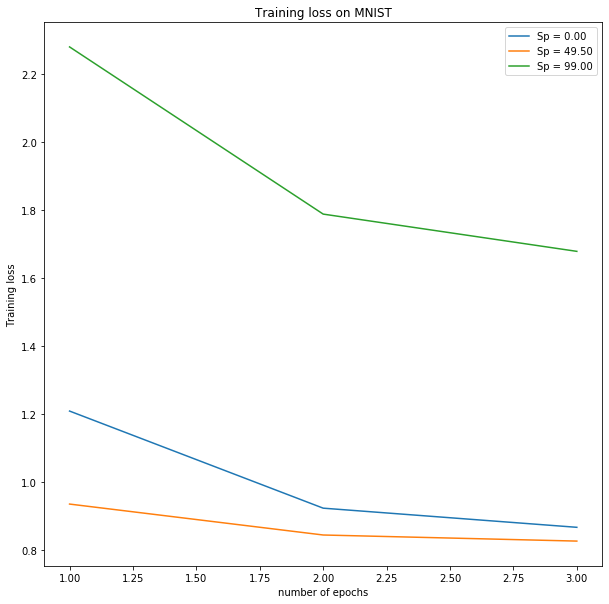

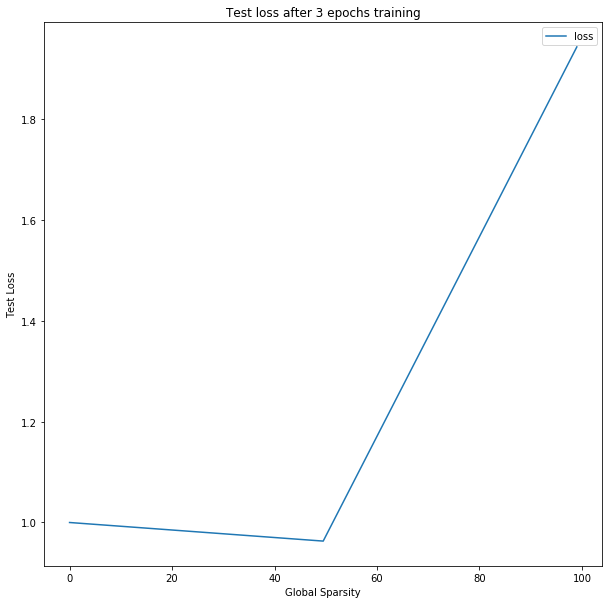

In [5]:
import matplotlib.pyplot as plt
from Visualizer import Visualizer

v = Visualizer(list_global_sparsity, list_epochs, lists_training_loss, list_test_loss)

a = v.show_training_loss_pruning()
plt.show()
b = v.show_test_loss()
plt.show()
